# Timeseries anomaly detection using LSTM-Autoencoder

## Introduction

This notebook shows how lstm autoencoder model detects anomalies in timeseries data.

In machine learning, anomaly detection is the task of identifying the rare events or observations which are suspicious and seem different from the majority of the data. These anomalies can indicate problems such as bank fraud, medical problems, failure of industrial equipment, etc. This code is based on [keras.io example](https://keras.io/examples/timeseries/timeseries_anomaly_detection/).

## Setup

In [1]:
!pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the dataset

[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

- `art_daily_small_noise.csv` : Training file 
- `art_daily_jumpsup.csv` : Test file

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [4]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [5]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Visualize the data
Data which seems sudden jump up is detected as an anomaly.

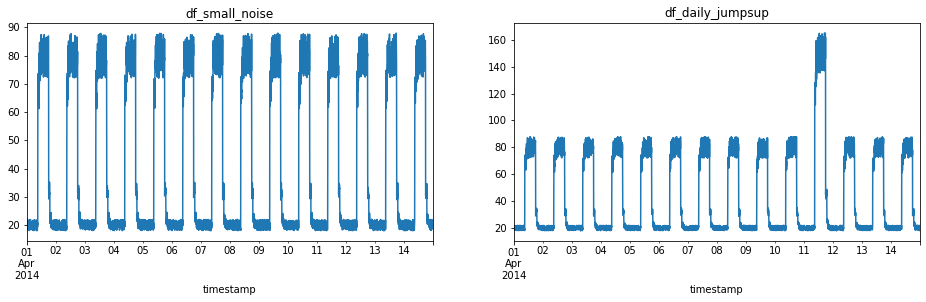

In [6]:
fig,(ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(16, 4)

df_small_noise.plot(title = 'df_small_noise', legend = False, ax = ax1)
df_daily_jumpsup.plot(title = 'df_daily_jumpsup', legend = False, ax = ax2)

plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the `value` data. The dataset have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [7]:
print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [8]:
# Normalize value and save result for normalizing test data
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [9]:
TIME_STEPS = 288

# Generated training sequences for use in the model
def create_sequences(values, time_steps = TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
        
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## Build a model

You build a LSTM autoencoder model. The model take input of shape `(batch_size, timesteps, n_features)` and return output of the same shape. In this case, `timesteps (sequence_length)` is 288 and `n_features` is 1.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed

timesteps = x_train.shape[1]
n_features = x_train.shape[2]

model = Sequential()
# Encoder
model.add(LSTM(32, input_shape = (timesteps, n_features)))
model.add(Dropout(0.2))
model.add(RepeatVector(timesteps))
# Decoder
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer = 'adam', loss = 'mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 288, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 288, 32)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
____________________________________________________

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [11]:
history = model.fit(x_train, x_train, epochs = 5, batch_size = 128, validation_split = 0.1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')],
)

Train on 3369 samples, validate on 375 samples
Epoch 1/5
3369/3369 [==============================] - 22s 6ms/sample - loss: 0.8796 - val_loss: 0.8352
Epoch 2/5
3369/3369 [==============================] - 16s 5ms/sample - loss: 0.8279 - val_loss: 0.8157
Epoch 3/5
3369/3369 [==============================] - 16s 5ms/sample - loss: 0.8183 - val_loss: 0.8127
Epoch 4/5
3369/3369 [==============================] - 17s 5ms/sample - loss: 0.8107 - val_loss: 0.8025
Epoch 5/5
3369/3369 [==============================] - 16s 5ms/sample - loss: 0.7954 - val_loss: 0.7956


### Plot training and validation loss

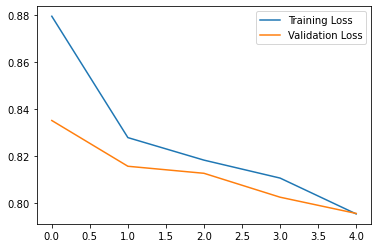

In [12]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

## Detecting anomalies

You will detect anomalies by determining how well our model can reconstruct the input data.

1. Find MAE loss on training samples.
2. Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. You will make this the `threshold` for anomaly detection.
3. If the reconstruction loss for a sample is greater than this `threshold` value then you can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an `anomaly`.

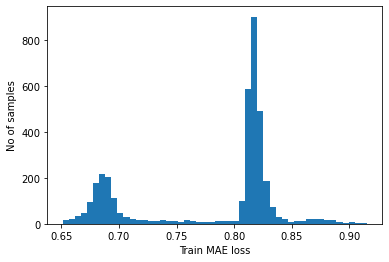

Reconstruction error threshold:  0.915189591077175


In [13]:
# Get train MAE loss
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)

plt.hist(train_mae_loss, bins = 50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

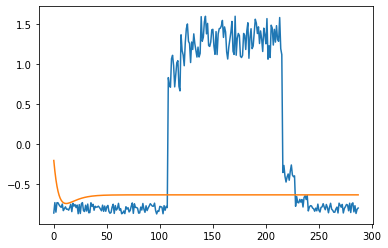

In [14]:
# Checking how the first sequence learned
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

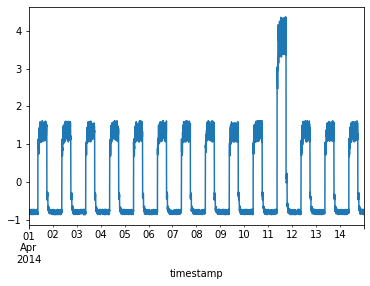

Test input shape:  (3744, 288, 1)


In [15]:
# Normalize test data
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend = False, ax = ax)
plt.show()

# Create sequences from test values
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

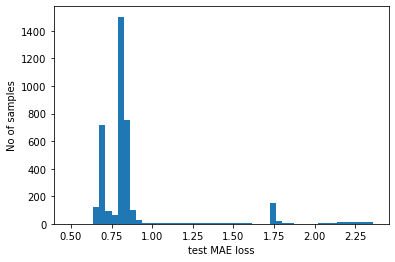

In [16]:
# Get test MAE loss
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins = 50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

## Plot anomalies

You now know the samples of the data which are anomalies. With this, you will find the corresponding `timestamps` from the original test data. You will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in `time_steps` number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [17]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []

for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

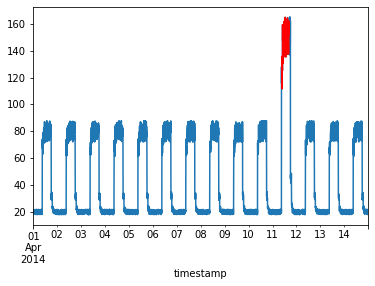

In [18]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend = False, ax = ax)
df_subset.plot(legend = False, ax = ax, color = "r")
plt.show()